# Model Prototype Object

Here we take a real [Rubin Data Preview 1 (DP1)](https://dp1.lsst.io/index.html) multi-band light curve and make simulations based on it.
We will use an eclipsing binary [CRTS J061939.7-244148](https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=CRTS+J061939.7-244148+&submit=SIMBAD+search), which was identified in the DP1 data by [arXiv:2506.23955](https://arxiv.org/abs/2506.23955).

Our plan is:
1. Get the light curve in ugrizy bands.
2. Period-fold it and fit with a smooth function.
3. Simulate this particular object with LSST cadence and noise properties.
4. Add samplable parameters, such as distance and period, and simulate a population.

In [ ]:
%pip install tdastro
# For data fitting
%pip install tinygp jax flax optax

In [2]:
import lsdb  # To get Rubin data
import matplotlib.pyplot as plt  # For plots
import numpy as np  # For math
import pandas as pd  # For tabular data


from tdastro.astro_utils.mag_flux import flux2mag, mag2flux  # AB mags <-> nJy
from tdastro.astro_utils.passbands import PassbandGroup  # Filter transmissions
from tdastro.base_models import FunctionNode  # Define custom parameter samplers
from tdastro.math_nodes.np_random import NumpyRandomFunc  # Parameter sampling with numpy.random
from tdastro.math_nodes.ra_dec_sampler import OpSimUniformRADECSampler  # Sky position sampling
from tdastro.opsim.opsim import OpSim  # Deal with LSST cadence and noise simulations
from tdastro.simulate import simulate_lightcurves
from tdastro.sources.lightcurve_source import LightcurveSource  # Source model


# For input data interpolation with tinygp
import flax.linen  # For optimizable model creation
import flax.linen.initializers as flax_init  # For parameter initialization
import jax  # Framework tinygp based on
import jax.numpy as jnp  # Jax's implementation of numpy's API
import optax  # Gradient slope optimization framework
from tinygp import kernels, GaussianProcess  # For interpolation

# Ask Jax to use float64, it is for numerical stability of interpolation
jax.config.update("jax_enable_x64", True)

### 1. Getting the light curve

We assume that you are on [Rubin Science Platform](https://data.lsst.cloud), so you can access Rubin DP1 data using [LSDB](https://lsdb.io).
We are going to use light-curve from the LINCC Frameworks', which includes AB magnitude values converted from band fluxes.
Please see details about accessing DP1 with LSDB here: https://lsdb.io/dp1

We will also use the [ZTF](https://www.ztf.caltech.edu) DR23 light curve, because it has a better phase coverage and would help to interpolate data better.
We are accessing ZTF data through the [SNAD Viewer](https://ztf.snad.space/dr23/view/258108100003289).

First, let's define few constants describing the object.

In [3]:
RA, DEC = 94.91623647, -24.6965211
# From Malanchev+2025
PERIOD = 0.2407795
# From Bailer-Jones+2021
# https://vizier.cds.unistra.fr/viz-bin/VizieR-5?-ref=VIZ68839f64fdcc9&-out.add=.&-source=I/352/gedr3dis&-c=094.91625157166%20-24.69649640201,eq=ICRS,rs=2&-out.orig=o
DISTANCE = 1653.999

##### Rubin DP1 data

In [4]:
dp1_nf = lsdb.open_catalog(
    '/rubin/lsdb_data/dia_object_collection/',
    columns=['ra', 'dec', 'diaObjectForcedSource'],
    search_filter=lsdb.ConeSearch(ra=RA, dec=DEC, radius_arcsec=1)
).compute()
dp1_lc = dp1_nf['diaObjectForcedSource'].iloc[0]
dp1_lc = dp1_lc.query(
    "~psfFlux_flag"
    " and ~psfDiffFlux_flag"
    " and ~pixelFlags_suspect"
    " and ~pixelFlags_saturated"
    " and ~pixelFlags_cr"
    " and ~pixelFlags_bad"
)

input_lsst_df = dp1_lc.rename(
    columns={"midpointMjdTai": "mjd", "psfMag": "mag", "psfMagErr": "magerr"}
)
input_lsst_df = input_lsst_df[["band", "mjd", "mag", "magerr"]]
input_lsst_df

,band,mjd,mag,magerr
0,y,60634.323548,16.521154,0.002976
1,y,60634.325417,16.536283,0.002972
...,...,...,...,...
198,r,60656.341488,16.823532,0.001334
199,r,60656.341913,16.821083,0.001311


##### ZTF data

In [5]:
input_ztf_df = pd.read_csv(
    "https://ztf.snad.space/dr23/csv/258108100003289?other_oid=258208100005846&min_mjd=50000&max_mjd=70000"
)
input_ztf_df = input_ztf_df.rename(columns={"filter": "band"})[["band", "mjd", "mag", "magerr"]]
input_ztf_df

,band,mjd,mag,magerr
0,zr,58397.52198,17.228245,0.018987
1,zr,58422.50484,16.731781,0.014676
...,...,...,...,...
457,zg,60608.46133,17.776928,0.031371
458,zr,60608.50506,16.915134,0.016023


##### All the data all together

In [6]:
input_df = pd.concat([input_lsst_df, input_ztf_df], axis=0, ignore_index=True)
mjd_min_light = input_df["mjd"][input_df.query("band == 'r'")["mag"].idxmax()]
input_df["phase"] = (input_df["mjd"] - mjd_min_light) % PERIOD / PERIOD
input_df

,band,mjd,mag,magerr,phase
0,y,60634.323548,16.521154,0.002976,0.352477
1,y,60634.325417,16.536283,0.002972,0.360237
...,...,...,...,...,...
653,zg,60608.461330,17.776928,0.031371,0.942095
654,zr,60608.505060,16.915134,0.016023,0.123714


#### Let's plot the light curve

ZTF bands have "z" prefix.

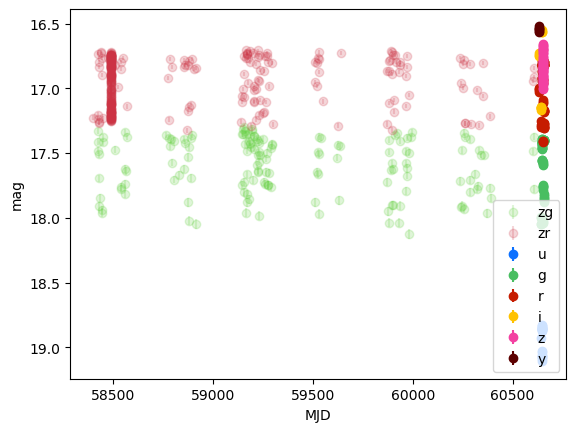

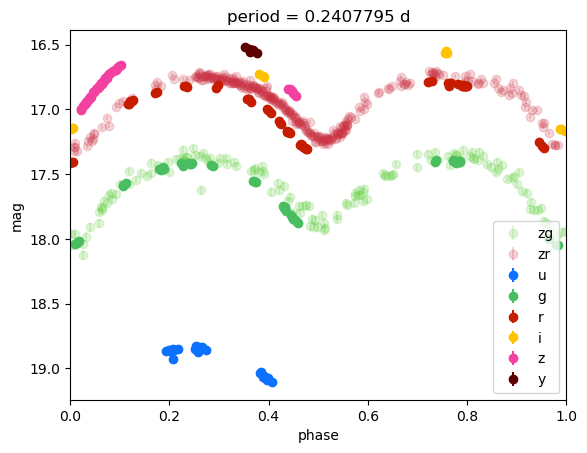

In [7]:
COLORS = {
    "u": "#0c71ff",
    "g": "#49be61",
    "r": "#c61c00",
    "i": "#ffc200",
    "z": "#f341a2",
    "y": "#5d0000",
    "zg": "#62D03E",
    "zr": "#CC3344",
}


def plot_lc(df, period=None):
    df = df.copy()
    if period is not None and "phase" not in df.columns:
        mjd_min_light = df["mjd"][df.query("band == 'r'")["mag"].idxmax()]
        df["phase"] = (df["mjd"] - mjd_min_light) % period / period
    if period is None:
        x_col = "mjd"
    else:
        x_col = "phase"
    plt.figure()
    if len({"zg", "zr"} & set(df["band"])) > 0:
        for band in ["zg", "zr"]:
            data = df.query("band == @band")
            plt.errorbar(
                data[x_col],
                data["mag"],
                yerr=data["magerr"],
                label=f"{band}",
                fmt="o",
                color=COLORS[band],
                alpha=0.2,
            )
    for band in "ugrizy":
        data = df.query("band == @band")
        plt.errorbar(
            data[x_col], data["mag"], yerr=data["magerr"], label=f"{band}", fmt="o", color=COLORS[band]
        )

    plt.gca().invert_yaxis()
    if period is None:
        plt.xlabel("MJD")
    else:
        plt.xlabel("phase")
        plt.xlim([0, 1])
        plt.title(f"{period = } d")
    plt.ylabel("mag")
    plt.legend(loc="lower right")


plot_lc(input_df, period=None)
plot_lc(input_df, period=PERIOD)

### 2. Make a smooth interpolation of a period-folded light-curve

We are using [`tinygp`](https://tinygp.readthedocs.io/) for Gaussian process fit of our data.
Our Gaussian process kernel has two components: a periodic one for correlation in time, and an exponential for wavelengths, which helps reconstruct Rubin light curves based on correlation with ZTF data.
We are going to use mean of the result Gaussian process as light curve "interpolation" result.

In [8]:
# https://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=LSST&asttype=
# https://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=Palomar&gname2=ZTF&asttype=
EFF_WAVELENGTH = {
    "u": 3751.20,
    "g": 4740.66,
    "r": 6172.34,
    "i": 7500.97,
    "z": 8678.90,
    "y": 9711.82,
    "zg": 4746.48,
    "zr": 6366.38,
}

LG_EFF_WAVELENGTH = {band: np.log10(v) for band, v in EFF_WAVELENGTH.items()}
LG_EFF_WAVELENGTH_BY_POSITION = jnp.array(list(LG_EFF_WAVELENGTH.values()))

MEAN_MAGS = jnp.array([input_df.query("band == @band")["mag"].mean() for band in LG_EFF_WAVELENGTH])

N_BANDS = len(LG_EFF_WAVELENGTH)
# Mapping like 'g' -> [0, 1, 0, 0, 0, 0, 0, 0]
BAND_ENCODINGS = {
    band: np.r_[[0] * i, 1.0, [0] * (N_BANDS - i - 1)] for i, band in enumerate(LG_EFF_WAVELENGTH)
}
BAND_ENCODINGS

{'u': array([1., 0., 0., 0., 0., 0., 0., 0.]),
 'g': array([0., 1., 0., 0., 0., 0., 0., 0.]),
 'r': array([0., 0., 1., 0., 0., 0., 0., 0.]),
 'i': array([0., 0., 0., 1., 0., 0., 0., 0.]),
 'z': array([0., 0., 0., 0., 1., 0., 0., 0.]),
 'y': array([0., 0., 0., 0., 0., 1., 0., 0.]),
 'zg': array([0., 0., 0., 0., 0., 0., 1., 0.]),
 'zr': array([0., 0., 0., 0., 0., 0., 0., 1.])}

Array([19.46199301, 19.46184849, 19.46155245, ..., 17.31521394,
       17.3153739 , 17.31538142], dtype=float64)

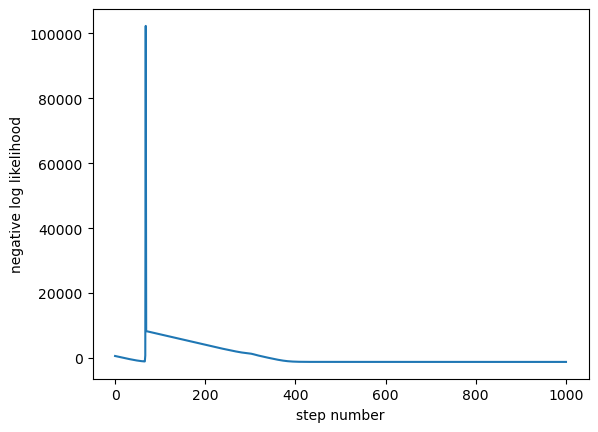

In [9]:
# Adopted from tinygp docs
# https://tinygp.readthedocs.io/en/stable/tutorials/quickstart.html
# https://tinygp.readthedocs.io/en/stable/tutorials/modeling.html#optimization-with-flax-optax


class PhaseDistance(kernels.Distance):
    """Distance between two points in phase, time being the first axis"""

    def distance(self, X1, X2):
        return jnp.sum(jnp.abs(X1[..., 0] - X2[..., 0]))


def get_band_idx(X):
    return jnp.sum(X[..., 1:].astype(int) * jnp.arange(N_BANDS), axis=-1)


class BandDistance(kernels.Distance):
    """Distance between two passbands, one-hot encoded in all axis but first"""

    def distance(self, X1, X2):
        ln_wave_1 = LG_EFF_WAVELENGTH_BY_POSITION[get_band_idx(X1)]
        ln_wave_2 = LG_EFF_WAVELENGTH_BY_POSITION[get_band_idx(X2)]
        return jnp.sum(jnp.abs(ln_wave_1 - ln_wave_2))


def get_mean(means, X):
    band_idx = get_band_idx(X)
    return means[band_idx]


class GPModule(flax.linen.Module):
    @flax.linen.compact
    def __call__(self, x, yerr, y, t):
        means = self.param("mean", lambda *_: MEAN_MAGS)
        periodic_var = jnp.exp(2.0 * self.param("ln_periodic_sigma", flax_init.zeros, ()))
        periodic_gamma = jnp.exp(self.param("ln_periodic_gamma", flax_init.zeros, ()))
        band_var = jnp.exp(2.0 * self.param("ln_band_sigma", flax_init.zeros, ()))
        band_scale = jnp.exp(self.param("ln_band_scale", flax_init.zeros, ()))
        extra_diag = jnp.exp(self.param("ln_extra_diag", flax_init.zeros, ()))

        periodic_kernel = periodic_var * kernels.ExpSineSquared(
            gamma=periodic_gamma,
            scale=1.0,
            distance=PhaseDistance(),
        )
        band_kernel = band_var * kernels.ExpSquared(scale=band_scale, distance=BandDistance())
        kernel = periodic_kernel + band_kernel

        gp = GaussianProcess(
            kernel,
            x,
            diag=yerr**2 + extra_diag,
            mean=lambda X: get_mean(means, X),
        )

        log_prob, gp_cond = gp.condition(y, t)
        return -log_prob, gp_cond.loc


band_one_hot = np.asarray([BAND_ENCODINGS[x] for x in input_df["band"]])
t = np.hstack([input_df["phase"].to_numpy()[:, None], band_one_hot])
y = input_df["mag"].to_numpy()
yerr = input_df["magerr"].to_numpy()
n_grid_band = 1000

phase_gp_grid = jnp.tile(jnp.linspace(0, 1, n_grid_band), N_BANDS)
band_gp_grid = np.repeat(list(BAND_ENCODINGS.keys()), n_grid_band)
band_gp_grid_one_hot = jnp.repeat(jnp.eye(N_BANDS), n_grid_band, axis=0)
t_gp_grid = jnp.hstack([phase_gp_grid[:, None], band_gp_grid_one_hot])

model = GPModule()


def loss(params):
    return model.apply(params, t, yerr, y, t_gp_grid)[0]


params = model.init(jax.random.PRNGKey(0), t, yerr, y, t_gp_grid)
tx = optax.sgd(learning_rate=3e-4)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(1001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
plt.xlabel("step number")

model.apply(params, t, yerr, y, t_gp_grid)[1]

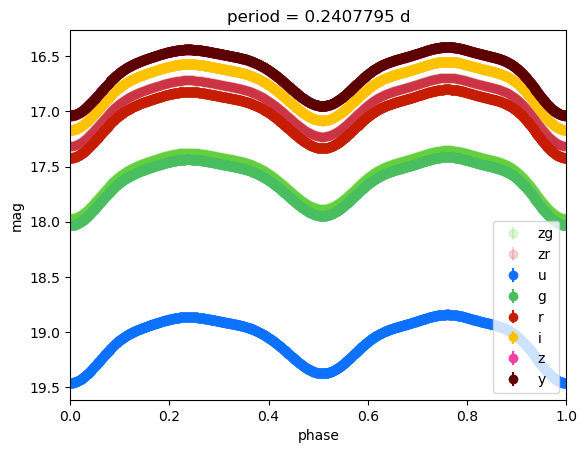

In [10]:
mag_pred_grid = model.apply(params, t, yerr, y, t_gp_grid)[1]
pred_df = pd.DataFrame(
    {
        "band": band_gp_grid,
        "mjd": phase_gp_grid * PERIOD,
        "mag": mag_pred_grid,
        "magerr": np.zeros(N_BANDS * n_grid_band),
    }
)
plot_lc(pred_df, period=PERIOD)

### 3. Simulate a single object

Now when we have a function which gives us apparent magnitude of our source for any of LSST (and two of ZTF!) passbands, we can use it to create a "light-curve source".
Let's start with the built-in `LightcurveSource` class, and in the next section we will extend it to simulate a population.

#### Create `LightcurveSource`

`LightcurveSource` class takes a "grid" model and interpolates it in time, with an optional support of periodic sources.
The grid model is basically "perfect" observations of our light curve, for all passbands.

**Note**: tdastro, as well as Rubin, operates with bandfluxes in nJy, not with magnitudes.

First of all, we will run our model on a grid, convert outputs to nJy, and reformat the result to use it with `LightcurveSource` constructor.
More specifically, the LightcurveSource model takes a dictionary mapping filter name to a `(T, 2)` array of the bandlfuxes in that filter where the first column is time and the second column is the flux density (in nJy).

In [11]:
def bandflux_model(phase, band):
    """Output bandflux in nJy for given MJD and band."""
    orig_shape = shape = np.broadcast_shapes(np.shape(phase), np.shape(band))
    if shape == ():
        shape = (1,)
    phase = np.broadcast_to(phase, shape)
    band = np.broadcast_to(band, shape)
    band_one_hot = np.asarray([BAND_ENCODINGS[x] for x in band])
    t_grid = np.hstack([phase[:, None], band_one_hot])
    mag = np.asarray(model.apply(params, t, yerr, y, t_grid)[1])
    flux = mag2flux(mag)
    return flux.reshape(orig_shape)

# Make a grid of phases covering a single period and all six LSST bassbands.
n_source_grid = 1000
phase_source_grid = np.linspace(0.0, 1.0, n_source_grid)
mjd_source_grid = phase_source_grid * PERIOD
# LSST bassbands only
lightcurve_grid = {
    band: np.stack([mjd_source_grid, bandflux_model(phase_source_grid, band)], axis=-1) for band in "ugrizy"
}

##### LSST cadence and noise simulations

Before we initialize the source, we need to get LSST cadence and noise simulations, OpSim.
You can either download it locally first, or make tdastro to fetch it for you.
Here we fetch it.

In [12]:
opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/baseline/baseline_v3.4_10yrs.db"
opsim_data = OpSim.from_url(opsim_url)

##### Initialize `LightcurveSource`

Let's initialize LightcurveSource object with our light curve grid and LSST passbands.
For simplicity, we will use the uniform sky position distribution.

In [13]:
# Time offset
lightcurve_t0 = NumpyRandomFunc("uniform", low=0.0, high=PERIOD)

# LSST Pabssands
lsst_passbands = PassbandGroup.from_preset("LSST")

fov_radius = np.sqrt(9.6 / np.pi)
radec_node = OpSimUniformRADECSampler(opsim_data, radius=fov_radius, node_label="radec")

lightcurve_source = LightcurveSource(
    lightcurves=lightcurve_grid,
    passbands=lsst_passbands,
    periodic=True,
    t0=lightcurve_t0,
    ra=radec_node.ra,
    dec=radec_node.dec,
)

#### Run a simulation!

Here we run just a single simulation, so the output would be a data frame with a single row only.

In [14]:
simulation = simulate_lightcurves(lightcurve_source, 1, opsim_data, lsst_passbands)
simulation

id         ra       dec  nobs     z  \
0   0  44.721365  11.28701   222  None   

                                              params  \
0  {'radec.ra': 44.72136532251077, 'radec.dec': 1...   

                                          lightcurve  
0  [{mjd: 60844.431414, filter: 'r', flux: 673659...

`lightcurve` columns represents a "nested" dataframe, using `nested-pandas`.
See [`nested-pandas` docs](https://nested-pandas.readthedocs.io/en/latest/) for more information.

In [15]:
simulated_lightcurve = simulation["lightcurve"].iloc[0]
simulated_lightcurve

,mjd,filter,flux,fluxerr,flux_perfect
0,60844.431414,r,673659.702595,1349.659012,676733.081856
1,60844.434504,r,672511.642680,1269.699660,673046.061499
...,...,...,...,...,...
220,64328.148317,g,391035.582688,496.134754,391284.882606
221,64328.172042,r,641854.965134,684.139167,643111.282498


Since we plot everything in magnitudes, let's convert fluxes and errors back to AB magnitudes.

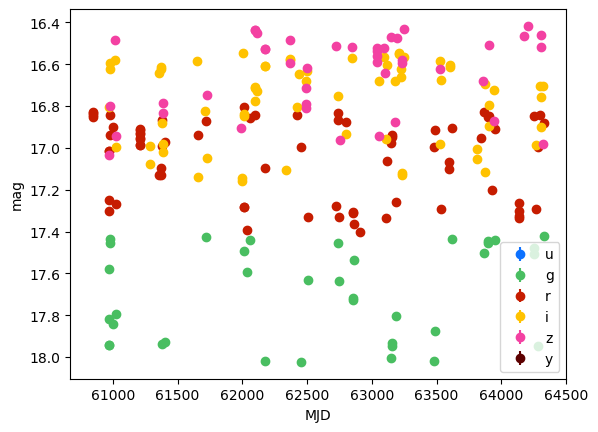

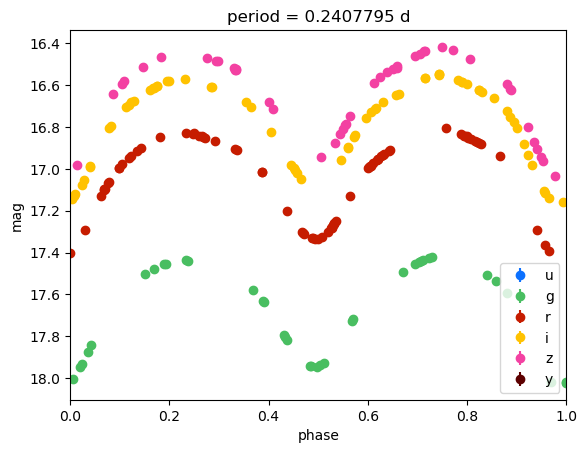

In [16]:
def flux_to_mag_df(df):
    df = df.copy()
    df = df.query("flux > 0")
    df["mag"] = flux2mag(df["flux"])
    df["magerr"] = 2.5 / np.log(10) * df["fluxerr"] / df["flux"]
    df["band"] = df["filter"]
    return df


mag_sim_lightcurve = flux_to_mag_df(simulated_lightcurve)
plot_lc(mag_sim_lightcurve, period=None)
plot_lc(mag_sim_lightcurve, period=PERIOD)

### Simulate a population.

We've just seen how 10-year LSST survey will fill the phase space for this object! After that, it would be interesting to see how a similar object located on a large distance would look like.
Again, we are not aimed to make the spatial distribution realistic, so we will use a simple power-law for the distance sampling.

#### Create a new Source class

First, we create a new Source class to incorporate new parameters we'd like to introduce.
For that we inherit from `LightcurveSource`, add new parameters, and change the output values accordingly.

In [17]:
class EclipsingSource(LightcurveSource):
    def __init__(
        self,
        lightcurves,
        passbands,
        *,
        distance_pc,
        period_day,
        phase0,
        **kwargs,
    ):
        super().__init__(
            lightcurves,
            passbands,
            periodic=True,
            baseline=None,
            # We set it to zero, because we adjust the phase with phase0 bellow
            t0=0.0,
            **kwargs,
        )
        self.add_parameter("distance_pc", value=distance_pc)
        self.add_parameter("period_day", value=period_day)
        self.add_parameter("phase0", value=phase0)

    def compute_bandflux(self, times, filters, state, **kwargs):
        params = self.get_local_params(state)

        phase = times / params["period_day"] - params["phase0"]
        real_object_bandflux = super().compute_bandflux(phase * PERIOD, filters, state, **kwargs)
        return real_object_bandflux * (DISTANCE / params["distance_pc"]) ** 2

#### Run simulations!

Let's create parameter distributions and initialize the Source class and the simulations.

In [18]:
# Let's define old parameters again

# Phase offset, sampled uniformly from 0.0 to 1.0
phase0 = NumpyRandomFunc("uniform", low=0.0, high=1.0)

# Period, sampled normally around the original period.
period_day = NumpyRandomFunc("normal", loc=PERIOD, scale=0.1 * PERIOD)

# LSST Passbands
lsst_passbands = PassbandGroup.from_preset("LSST")

# Uniform positional distribution
fov_radius = np.sqrt(9.6 / np.pi)
radec_node = OpSimUniformRADECSampler(opsim_data, radius=fov_radius, node_label="radec")

# Homogeneous distance distribution, up to 20kpc
max_distance_pc = 20_000.0
distance_pc = FunctionNode(
    lambda rnd: rnd * max_distance_pc,
    node_label="distance_pc",
    rnd=NumpyRandomFunc("power", a=2),
)

eclipsing_source = EclipsingSource(
    lightcurves=lightcurve_grid,
    passbands=lsst_passbands,
    distance_pc=distance_pc,
    period_day=period_day,
    phase0=phase0,
    ra=radec_node.ra,
    dec=radec_node.dec,
)

sims = simulate_lightcurves(
    eclipsing_source,
    100,
    opsim_data,
    lsst_passbands,
    param_cols=["distance_pc.function_node_result", "EclipsingSource_0.period_day"],
)
sims = sims.drop(columns=["params"])
sims = sims.rename(
    columns={
        "distance_pc_function_node_result": "distance",
        "EclipsingSource_0_period_day": "period",
    }
)
sims

id          ra        dec  nobs     z      distance    period  \
0    0  264.221591   6.660029   865  None   5452.314523  0.244476   
1    1   81.971408 -19.536553   858  None  15248.846922  0.236374   
..  ..         ...        ...   ...   ...           ...       ...   
98  98   35.594728  -8.277736   889  None  19030.155688  0.290559   
99  99  173.200044 -13.125619   902  None  19894.591405  0.240280   

                                           lightcurve  
0   [{mjd: 60800.40249, filter: 'r', flux: 62141.8...  
1   [{mjd: 60953.281524, filter: 'y', flux: 9947.0...  
..                                                ...  
98  [{mjd: 60896.353398, filter: 'y', flux: 5921.7...  
99  [{mjd: 60796.147278, filter: 'g', flux: 1804.5...  

[100 rows x 8 columns]

(26.0, 21.0)

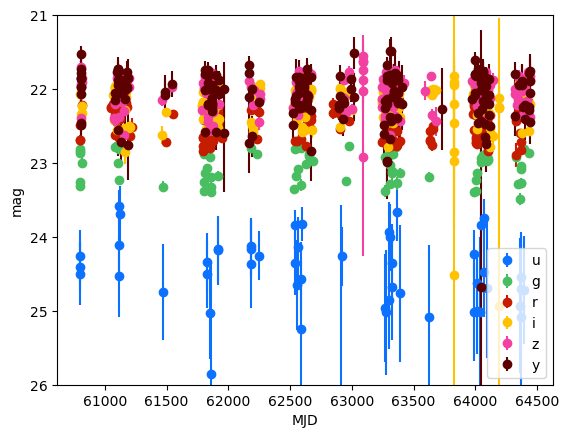

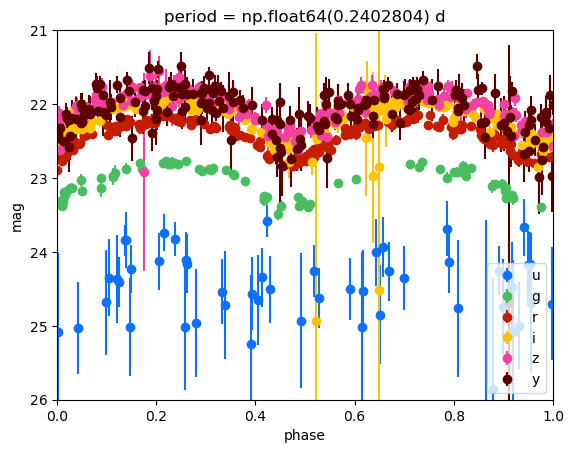

In [19]:
furthest_row = sims.loc[sims["distance"].idxmax()]
model_eclipsing = furthest_row["lightcurve"]

plot_lc(flux_to_mag_df(model_eclipsing), period=None)
plt.ylim([26, 21])

plot_lc(flux_to_mag_df(model_eclipsing), period=np.round(furthest_row["period"], 7))
plt.ylim([26, 21])